In [58]:
# Load pickled data
import pickle
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as m_image
from pandas.io.parsers import read_csv
import cv2
from sklearn.utils import shuffle
from skimage import exposure
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import math 
from math import ceil
import os
import sys
import glob
%matplotlib inline

# TODO: Fill this in based on where you saved the training and testing data
class traffic_sign_classifier(object):
    def __init__(self,rate=0.001,epochs=5,keep_prob=1.0,batch_size=128,learning_curve=False,save_model=False,test_model=False,norm=False,new_image=False):
        
        #Input files for the classifier
        self.signnames = read_csv("signnames.csv").values[:, 1]
        self.training_file = "input/train.p"
        self.validation_file= "input/valid.p"
        self.testing_file = "input/test.p"
        
        #List for data
        self.X_train = [] # Training Data
        self.y_train = [] # Training labels
        self.X_valid = [] # validation data 
        self.y_valid = [] # validation labels
        self.X_test = [] # test data 
        self.y_test = [] # test labels 
        self.images_dir = []
        self.X_new = []  # Ramdom image's test features 
        self.y_new = []  # Random image's test labels

     
        # Create dictionary for unique traffic signals
        self.unique_signs_dict = {} # each classID is presented: total 43 classes
        
        #visualiization parameters
        self.plot_row = 8 # row numbers
        self.plot_col = 6 # column numbers
        
             
        #Other parameters
        self.learning_curve = learning_curve
        self.norm = norm
        self.new_image = new_image
        
        #Loading Data
        self.load_data()
                
        #Model Architecture Information
        self.mu = 0
        self.sigma = 0.1
        # --> Convolution Layer1 
        # Gray color space only 1-channel 
        self.conv1_shape_g = (5, 5, 1, 32) # Filter shape gray color space
        self.conv1_shape = (5, 5, 3, 32) # Filter shape for color space
        self.conv1_strides=[1, 1, 1, 1] # Convolution Layer1 Strides
        # --> Pooling Layer1
        self.conv1_pooling_ksize=[1, 2, 2, 1] # Kernel size
        self.conv1_pooling_strides=[1, 2, 2, 1] # Pooling strides
        # --> Convolution Layer2
        self.conv2_shape = (5, 5, 32, 64) # Filter shape for color space
        self.conv2_strides=[1, 1, 1, 1] #Convolution Layer2 Strides
        # --> Pooling Layer2
        self.conv2_pooling_ksize=[1, 2, 2, 1] # Kernel size
        self.conv2_pooling_strides=[1, 2, 2, 1] # Pooling strides
        # --> Dropout
        self.keep_prob=keep_prob # Dropping 50% of the data
        # --> Fully connected Layer1
        self.fc1_shape = (1600, 540) # flattening the connections
        # --> Fully connected Layer2
        self.fc2_shape = (540, 180) # flattening the connections
        # --> Fully connected Layer3
        self.fc3_shape = (180,86)   # flattening the connections     
        # --> Fully connected Layer4
        self.fc4_shape = (86, self.n_classes) # flattening the connections         
       
        #Training Model Variables:
        self.rate = rate
        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size
        if (self.EPOCHS <= 10):
            self.epoch_print = 1;
        elif (self.EPOCHS <= 50):
            self.epoch_print = 10
        else:
            self.epoch_print = 50
        
        #Training Efficiency
        self.save = save_model
        self.test = test_model
 
        # Training Pipeline Variables      
        # Creating placeholder for y
        self.y = tf.placeholder(tf.int32,(None)) 
        self.one_hot_y = tf.one_hot(self.y, self.n_classes)
        
        # Top prediction parameters
        self.top_pred = [] # top predictions list
        self.k = 5 # number of top predictions
        

    
        
    def load_data(self):
        with open(self.training_file, mode='rb') as f:
            train = pickle.load(f)
        with open(self.validation_file, mode='rb') as f:
            valid = pickle.load(f)
        with open(self.testing_file, mode='rb') as f:
            test = pickle.load(f)
            
        self.X_train, self.y_train = train['features'], train['labels']
        self.X_valid, self.y_valid = valid['features'], valid['labels']
        self.X_test, self.y_test = test['features'], test['labels']
        self.images_dir = sorted(glob.glob('./images/*.jpg'))
        for path in self.images_dir:
            new_feature_data = cv2.imread(path) 
            new_label_data = path.split('.jpg')[0] 
            new_label_data = (new_label_data.split('_')[-1])
            self.X_new.append(new_feature_data)
            self.y_new.append(int(new_label_data))
            
                    
        ### Replace each question mark with the appropriate value. 
        ### Use python, pandas or numpy methods rather than hard coding the results
        
        # TODO: Number of training examples
        self.n_train = self.y_train.shape[0]
        
        # TODO: Number of validation examples
        self.n_validation = self.y_valid.shape[0]
        
        # TODO: Number of testing examples.
        self.n_test = self.y_test.shape[0]
        
        # TODO: What's the shape of an traffic sign image?
        #image_shape = X_train.shape[0]
        self.image_shape = self.X_train[0].shape
        
        # TODO: How many unique classes/labels there are in the dataset.
        self.unique_array, self.unique_indices, self.unique_counts = np.unique(self.y_train, return_inverse = False, return_index = True, return_counts = True)
        self.n_classes = self.unique_array.shape[0]
           
    def plot_distribution(self):
        plt.figure(figsize=(15,6))  
        plt.title('{}'.format("German Traffic Signal Data Distribution"))
        plt.ylabel('{}'.format("Frequency"))
        plt.xlabel('{}'.format("Traffic Sign Labels"))
        plt.hist(self.y_train,bins=self.n_classes,facecolor='blue')
        plt.grid(True)        
        plt.show()        

    def print_data_summary(self):
        print("Number of training examples =", self.n_train)
        print("Number of validation examples =", self.n_validation)
        print("Number of testing examples =", self.n_test)
        print("Image data shape =", self.image_shape)
        print("Number of classes =", self.n_classes)
        
        ### Data exploration visualization code goes here.
        ### Feel free to use as many code cells as needed.
        # Visualizations will be shown in the notebook.

        
    def unique_signs(self):
        dict_len = len(np.unique(self.y_train))
        for i in range(self.X_train.shape[0]):
            if (len(self.unique_signs_dict) == dict_len):
                return self.unique_signs_dict
            else:
                self.unique_signs_dict[self.y_train[i]] = self.X_train[i]
                
    def plot_image(self,image_data):
        plt.figure(figsize=(2.5*self.plot_col,2.5*self.plot_row))  
        for i in range(len(image_data)):
            plt.subplot(self.plot_row,self.plot_col,i+1)
            plt.imshow(image_data[i])
            plt.text(0, 0, '{}: {}'.format(i, self.signnames[i]), color='k',backgroundcolor='gray', fontsize=9)   
            plt.text(0, image_data[i].shape[0]-3, '{}'.format(image_data[i].shape), color='k',backgroundcolor='g', fontsize=9) 
        plt.show()
        
    def plot_top_prediction(self):
        print('-' * 80)
        print('Top 5 Predictions')
        print('-' * 80)
        cols = 1
        rows = int(len(self.top_pred.indices)/cols)
        plt.figure(figsize=(3.5*cols,3.5*rows))
        for i in range(rows):
            plt.subplot(rows+1,cols,i+1)
            if (self.y_new[i] != self.top_pred.indices[i][0]):
                plt.title("Wrong Prediction: {} ".format(self.signnames[self.top_pred.indices[i][0]], color='red'))
            else:
                plt.title("Right Prediction: {} ".format(self.signnames[self.top_pred.indices[i][0]],color='blue'))
            for j in range(self.k):
                plt.text(np.array(self.X_new[i]).shape[0]+3,5*(j+1),"Prediction: ({:.2f}%) --> {}".format(100*self.top_pred.values[i][j],self.signnames[self.top_pred.indices[i][j]]))
            plt.imshow(self.X_new[i])           
        plt.show()    
 
    def data_exploration(self):
        for index, u_index, u_count in zip(range(0,3), self.unique_indices, self.unique_counts):
            print("Data Exploration for ClassID: %i: %s" %(index, self.signnames[index]))
            fig = plt.figure(figsize = (6, 1))
            fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.1, wspace = 0.1)
            random_indices = random.sample(range(u_index,u_index+u_count), 10)
            for i in range(10):
                axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
                axis.imshow(self.X_train[random_indices[i]])
            plt.show()
            
    def show_learning_curve(self,learning):
        learning = np.array(learning)
        epochs = learning[:,0]
        train = learning[:,1]
        valid = learning[:,2]
        plt.figure(figsize=(10, 10))
        plt.plot(epochs, train, label='train')
        plt.plot(epochs, valid, label='validation')
        plt.title('Learning Curve')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.xticks(np.arange(0,self.EPOCHS,self.epoch_print))
        plt.legend(loc='center right')
        plt.show()
        
    def plot_new_image(self):
        print('-' * 80)
        print('New Images for Random Testing')
        print('-' * 80)
        plt.figure(figsize=(15,5))
        for index, img in enumerate(self.X_new):
            plt.subplot(2,4,index+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])    
        plt.show()

    ### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
    ### converting to grayscale, etc.
    ### Feel free to use as many code cells as needed.
    # Normalize images
    def image_normalization(self,X):
        return (X - X.mean())/X.std()
        
    # Image augmentation
    def transform_image(self, x, name):
        converters ={'Gray': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2GRAY)),
              'HSV': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2HSV)),
              'HLS': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2HLS)),
              'Lab': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2Lab)),
              'Luv': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2Luv)),
              'XYZ': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2XYZ)),
              'Yrb': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2YCrCb)),
              'YUV': (cv2.cvtColor(x.astype(np.float32), cv2.COLOR_RGB2YUV))}
        x = converters[name]
        return x

    
    # preprocess the image color space
    def preprocess_data(self,X,name):
        image_list = []
        
        #Image Normalization
        if (self.norm):
            X = self.image_normalization(X) 
                   
        #Transfor color space
        augmenter = lambda x: self.transform_image(x,name) 
        [image_list.append(augmenter(X[i])) for i in range(X.shape[0])]
        if (name =='Gray'):
            image_list = np.reshape(image_list,(-1,32,32,1))
        else:
            image_list = np.reshape(image_list,(-1,32,32,3))         
        return image_list
    ############################################################### 
        ### Define your architecture here.
        ### Feel free to use as many code cells as needed.
    def conv_layer(self,input_data,conv_shape_W,conv_strides, mu, sigma,padding_type):
        conv_W = tf.Variable(tf.truncated_normal(shape=conv_shape_W, mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_shape_W[3]))
        return (tf.nn.conv2d(input_data, conv_W, strides=conv_strides, padding=padding_type) + conv_b)
                    
    def fully_connected_layer(self,fc_input,fc_shape,mu,sigma):
        fc_W = tf.Variable(tf.truncated_normal(shape=fc_shape, mean = mu, stddev = sigma))
        fc_b = tf.Variable(tf.zeros(fc_shape[1]))
        return (tf.matmul(fc_input, fc_W) + fc_b)

        
    def activation_layer(self,conv):
        return (tf.nn.relu(conv))
        
    def pool_layer(self,conv,conv_pooling_ksize,conv_pooling_strides,padding_type):
        return (tf.nn.max_pool(conv, ksize= conv_pooling_ksize, strides= conv_pooling_strides,padding=padding_type))

    def LeNet(self,x,name):    
        # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
        if(name == 'Gray'):
            conv1_shape = self.conv1_shape_g
        else:
            conv1_shape = self.conv1_shape
        conv1 = self.conv_layer(x,conv1_shape,self.conv1_strides,self.mu,self.sigma,'VALID')
        # SOLUTION: Activation.
        conv1 = self.activation_layer(conv1)
        # SOLUTION: Pooling. Input = 28x28x32. Output = 14x14x32
        conv1 = self.pool_layer(conv1, self.conv1_pooling_ksize, self.conv1_pooling_strides,'VALID')
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x64.
        conv2 = self.conv_layer(conv1,self.conv2_shape,self.conv2_strides,self.mu,self.sigma,'VALID')            
        # SOLUTION: Activation.
        conv2 = self.activation_layer(conv2)        
        # SOLUTION: Pooling. Input = 10x10x64. Output = 5x5x64
        conv2 = self.pool_layer(conv2, self.conv2_pooling_ksize, self.conv2_pooling_strides,'VALID')
        #Dropout
        conv2 = tf.nn.dropout(conv2, self.keep_prob)        
        # SOLUTION: Flatten. Input = 5x5x64. Output = 1600.
        fc0   = flatten(conv2)
        # SOLUTION: Layer 3: Fully Connected. Input = 1600. Output = 540.
        fc1 = self.fully_connected_layer(fc0,self.fc1_shape,self.mu,self.sigma)
        # SOLUTION: Activation.
        fc1    = self.activation_layer(fc1)
        # SOLUTION: Layer 4: Fully Connected. Input = 540. Output = 180.
        fc2 = self.fully_connected_layer(fc1,self.fc2_shape,self.mu,self.sigma)
        # SOLUTION: Activation.
        fc2 = self.activation_layer(fc2)
        # SOLUTION: Layer 5: Fully Connected. Input = 190. Output = 86
        #logits = self.fully_connected_layer(fc2,self.fc3_shape,self.mu,self.sigma)
        fc3 = self.fully_connected_layer(fc2,self.fc3_shape,self.mu,self.sigma)
        # SOLUTION: Activation.
        fc3    = self.activation_layer(fc3)
        # SOLUTION: Layer 6: Fully Connected. Input = 86. Output = 43.
        logits = self.fully_connected_layer(fc3,self.fc4_shape,self.mu,self.sigma)            
        return logits

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.


    # Training model and testing
    def training_pipeline(self,name):
        # Creating place holder for X
        #    Gray color space has only 1 channel
        #    Color Space has 3 channels
        if (name =='Gray'): 
            self.X = tf.placeholder(tf.float32, (None, self.X_test.shape[1], self.X_test.shape[2], 1)) 
        else: 
            self.X = tf.placeholder(tf.float32, (None, self.X_test.shape[1], self.X_test.shape[2], 3)) # Creating placeholder for X
        logits = self.LeNet(self.X,name)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y,logits=logits )
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.rate)
        training_operation = optimizer.minimize(loss_operation)
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(self.one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        y_pred = tf.nn.softmax(logits)
        pred = tf.nn.top_k(y_pred,k=self.k)
        saver = tf.train.Saver()
    
        def evaluate(self,X_data, y_data):
            num_examples = len(X_data)
            total_accuracy = 0
            sess = tf.get_default_session()
            for offset in range(0, num_examples, self.BATCH_SIZE):
                batch_x, batch_y = X_data[offset:offset+self.BATCH_SIZE], y_data[offset:offset+self.BATCH_SIZE]
                accuracy = sess.run(accuracy_operation, feed_dict={self.X: batch_x, self.y: batch_y})
                total_accuracy += (accuracy * len(batch_x))
            return total_accuracy / num_examples

        def evaluate_model_with_new_img(self):
            with tf.Session() as sess:
                saver.restore(sess, tf.train.latest_checkpoint('.'))
                feed_dict = {self.X: self.X_new, self.y: self.y_new}
                self.top_pred = sess.run(pred, feed_dict=feed_dict)
                self.plot_top_prediction()
        
        def evaluate_model(self):
            with tf.Session() as sess:
                saver.restore(sess, tf.train.latest_checkpoint('.'))
                test_accuracy = evaluate(self,self.X_test, self.y_test)
                print("Test Accuracy = {:.3f}".format(test_accuracy))
      
        def training_model(self):
            learning=[]
            with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                num_examples = len(self.X_train)
                
                print("Training...")
                print()
                for i in range(self.EPOCHS):
                    self.X_train, self.y_train = shuffle(self.X_train, self.y_train)
                    for offset in range(0, num_examples, self.BATCH_SIZE):
                        end = offset + self.BATCH_SIZE
                        batch_x, batch_y = self.X_train[offset:end], self.y_train[offset:end]
                        sess.run(training_operation, feed_dict={self.X: batch_x, self.y: batch_y})
                    
                    training_accuracy = evaluate(self,self.X_train, self.y_train)    
                    validation_accuracy = evaluate(self,self.X_valid, self.y_valid)
                    learning.append([i+1,training_accuracy,validation_accuracy])
                    if ((i+1)%self.epoch_print == 0):
                        print("EPOCH {} ...".format(i+1))
                        print("Training Accuracy = {:.3f}".format(training_accuracy))                        
                        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                        print()
                

                if (self.save):    
                    saver.save(sess, './lenet')
                    print("Model saved")
                if (self.learning_curve):
                    print("Learning Curve...")
                    self.show_learning_curve(learning)
                if (self.test):
                    print("evaluating Test Data...")
                    evaluate_model(self)
                if (self.new_image):
                    self.plot_new_image()
                    print("evaluating New Data...")
                    evaluate_model_with_new_img(self)
            
        return training_model(self)
        

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


#Step 0: Load The Data
The initiaizer function in Traffic sign classifier class calls load_data function which will load training, validation, testing and web images that will be used for testing.

In [59]:
tsc = traffic_sign_classifier()

#Step 1: Print Dataset Summary
The total number of training, validation and testing samples used in model will be printed. The image shape (height, width,channel), and number of unique classes/labels are printed.

In [13]:
tsc.print_data_summary()

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#Step 2: Visualization of data sets
##Histogram of the Training data
The histogram plot of the training data indicates skewed data with few samples less than 100 and while some greater than 1000. Also the histogram is plotten against the unique traffic signs. 

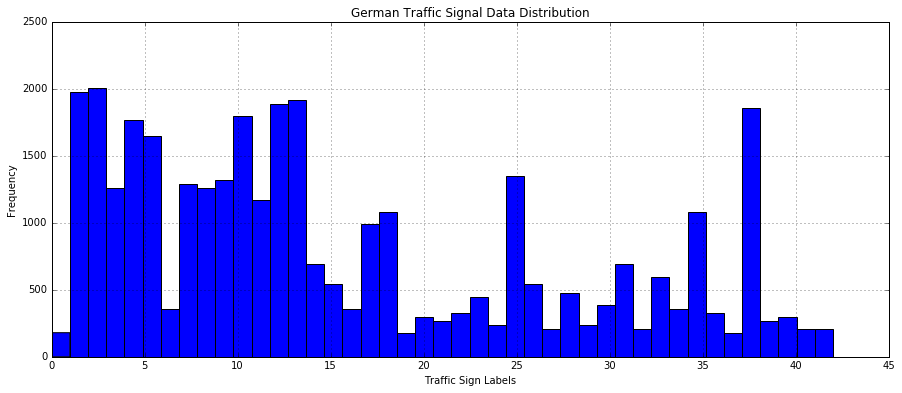

In [15]:
tsc.plot_distribution()

##unique signs in Training data:
There is 43 unique traffic signs with classID and shape (WxHxChannel) infomation. Also plotted 10 random images from 3 random classes to visualize the kind of data that will b used to train the model.

Data Exploration:


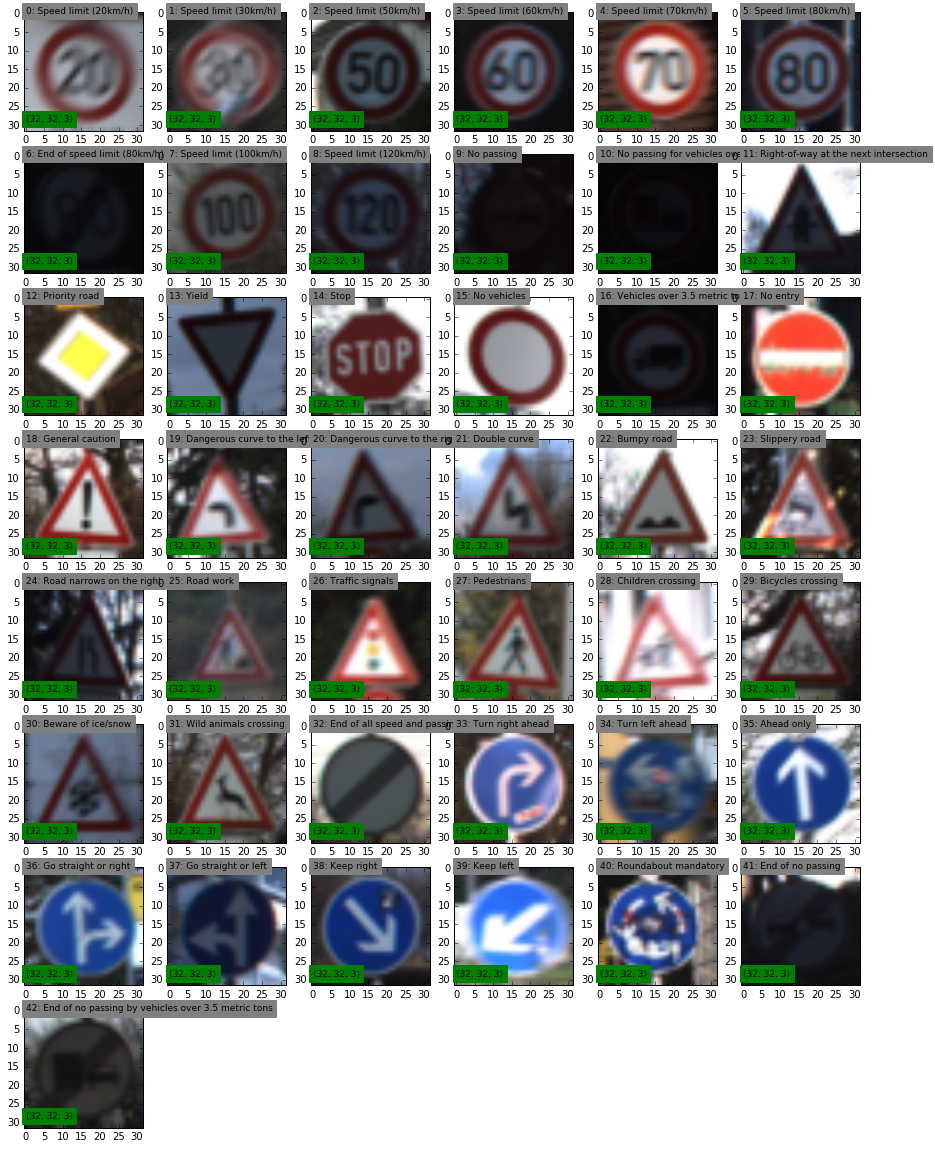

Data Exploration for ClassID: 0: Speed limit (20km/h)


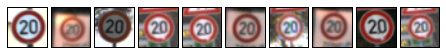

Data Exploration for ClassID: 1: Speed limit (30km/h)


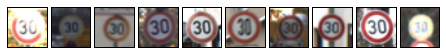

Data Exploration for ClassID: 2: Speed limit (50km/h)


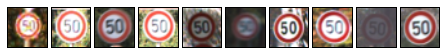

In [16]:
unique_signs_dict = tsc.unique_signs()
print("Data Exploration:")
tsc.plot_image(unique_signs_dict)
tsc.data_exploration()

#Step 3: Design and Test a Model Architecture
An additional fully connected layer and dropout layer were added to improve the accuracy of the validation data set original LeNet model by generalizing.The training data was preprocessed to be converted into different color space to identify the best suitable one.Conversion to gray scale and yuv space showed increased validation accuracy than other conversion techniques (0.888).

In [46]:
color =['Gray','HSV', 'HLS', 'Lab', 'Luv', 'XYZ', 'Yrb', 'YUV']
for name in color:
    print('Color Space: {}'.format(name))
    tsc.__init__(epochs=20)
    print("preprocessing...")
    tsc.X_train = tsc.preprocess_data(tsc.X_train,name)
    tsc.X_valid = tsc.preprocess_data(tsc.X_valid,name)
    print("preprocessing Completed")
    tsc.training_pipeline(name)  

Color Space: Gray
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.974
Validation Accuracy = 0.871

EPOCH 20 ...
Training Accuracy = 0.984
Validation Accuracy = 0.889

Color Space: HSV
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.629
Validation Accuracy = 0.450

EPOCH 20 ...
Training Accuracy = 0.962
Validation Accuracy = 0.631

Color Space: HLS
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.452
Validation Accuracy = 0.373

EPOCH 20 ...
Training Accuracy = 0.937
Validation Accuracy = 0.721

Color Space: Lab
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.056
Validation Accuracy = 0.054

EPOCH 20 ...
Training Accuracy = 0.058
Validation Accuracy = 0.054

Color Space: Luv
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.058
Validation Accuracy = 0.054

EPOCH 20 ...
Training Accuracy =

Normalization of the data showed an increase in the validation accuracy (0.916) and training accuracy(0.996). But it appears like there is an oscillation in the validation accuracy.

In [62]:
tsc.__init__(norm=True)
color =['YUV']
for name in color:
    print('Color Space: {}'.format(name))
    print("preprocessing...")
    tsc.X_train = tsc.preprocess_data(tsc.X_train,name)
    tsc.X_valid = tsc.preprocess_data(tsc.X_valid,name)
    print("preprocessing Completed")
    tsc.training_pipeline(name)  

Color Space: YUV
preprocessing...
preprocessing Completed
Training...

EPOCH 1 ...
Training Accuracy = 0.946
Validation Accuracy = 0.845

EPOCH 2 ...
Training Accuracy = 0.964
Validation Accuracy = 0.866

EPOCH 3 ...
Training Accuracy = 0.989
Validation Accuracy = 0.901

EPOCH 4 ...
Training Accuracy = 0.993
Validation Accuracy = 0.927

EPOCH 5 ...
Training Accuracy = 0.996
Validation Accuracy = 0.916



In order to overcome the oscillation in the accuracy, learning rate was redduced by 10.

In [63]:
tsc.__init__(norm=True,rate=0.0001)
color =['YUV']
for name in color:
    print('Color Space: {}'.format(name))
    print("preprocessing...")
    tsc.X_train = tsc.preprocess_data(tsc.X_train,name)
    tsc.X_valid = tsc.preprocess_data(tsc.X_valid,name)
    print("preprocessing Completed")
    tsc.training_pipeline(name)  

Color Space: YUV
preprocessing...
preprocessing Completed
Training...

EPOCH 1 ...
Training Accuracy = 0.626
Validation Accuracy = 0.498

EPOCH 2 ...
Training Accuracy = 0.835
Validation Accuracy = 0.645

EPOCH 3 ...
Training Accuracy = 0.913
Validation Accuracy = 0.746

EPOCH 4 ...
Training Accuracy = 0.944
Validation Accuracy = 0.796

EPOCH 5 ...
Training Accuracy = 0.953
Validation Accuracy = 0.801



Since the validation accuracy is close to what is expected, augmentation of data is not really required. In order to achieve a robust model, a drop out was set to 50% after second convolution layer. A decrease in the learning rate triggers a need to increase the total number of epochs.

Color Space: YUV
preprocessing...
preprocessing Completed
Training...

EPOCH 10 ...
Training Accuracy = 0.943
Validation Accuracy = 0.848

EPOCH 20 ...
Training Accuracy = 0.980
Validation Accuracy = 0.895

EPOCH 30 ...
Training Accuracy = 0.989
Validation Accuracy = 0.910

EPOCH 40 ...
Training Accuracy = 0.992
Validation Accuracy = 0.920

EPOCH 50 ...
Training Accuracy = 0.996
Validation Accuracy = 0.929

Learning Curve...


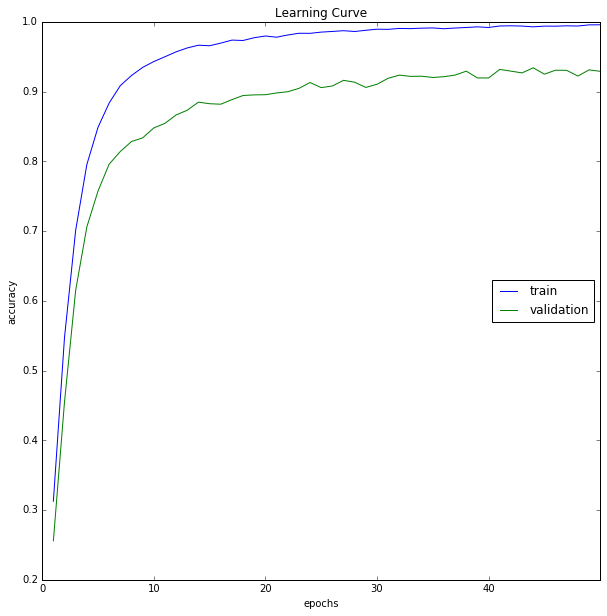

In [48]:
tsc.__init__(norm=True,epochs=50,rate=0.0001,learning_curve=True,keep_prob=0.5,batch_size=128)
color =['YUV']
for name in color:
    print('Color Space: {}'.format(name))
    print("preprocessing...")
    tsc.X_train = tsc.preprocess_data(tsc.X_train,name)
    tsc.X_valid = tsc.preprocess_data(tsc.X_valid,name)
    print("preprocessing Completed")
    tsc.training_pipeline(name)  

From the results, it looks like we need to add more epochs to have better accuracy.

Color Space: YUV
preprocessing...
preprocessing Completed
Training...

EPOCH 50 ...
Training Accuracy = 0.996
Validation Accuracy = 0.932

EPOCH 100 ...
Training Accuracy = 0.997
Validation Accuracy = 0.933

EPOCH 150 ...
Training Accuracy = 0.999
Validation Accuracy = 0.938

EPOCH 200 ...
Training Accuracy = 0.999
Validation Accuracy = 0.946

Model saved
Learning Curve...


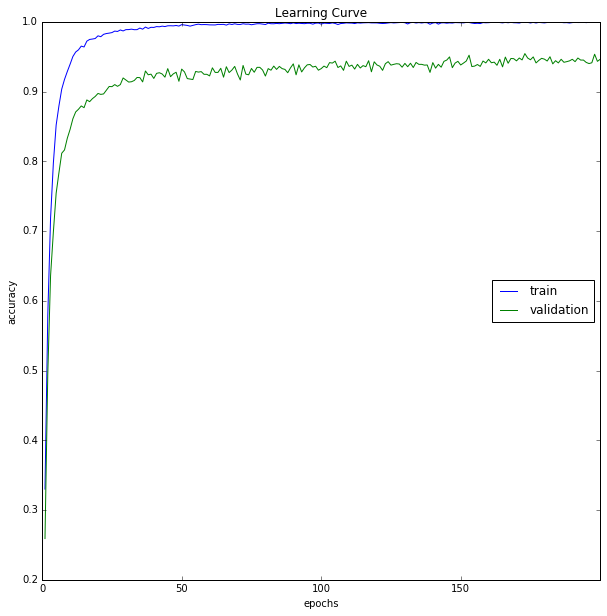

evaluating Test Data...
Test Accuracy = 0.939
--------------------------------------------------------------------------------
New Images for Random Testing
--------------------------------------------------------------------------------


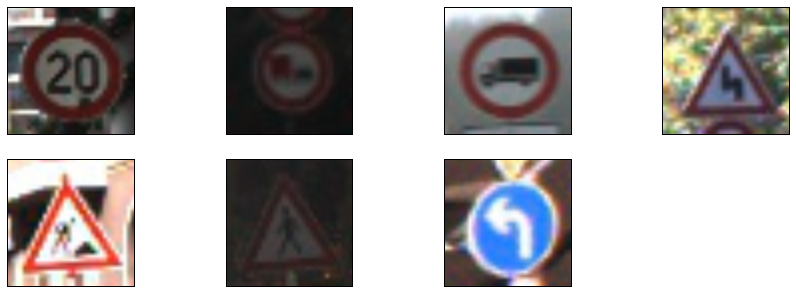

evaluating New Data...
--------------------------------------------------------------------------------
Top 5 Predictions
--------------------------------------------------------------------------------


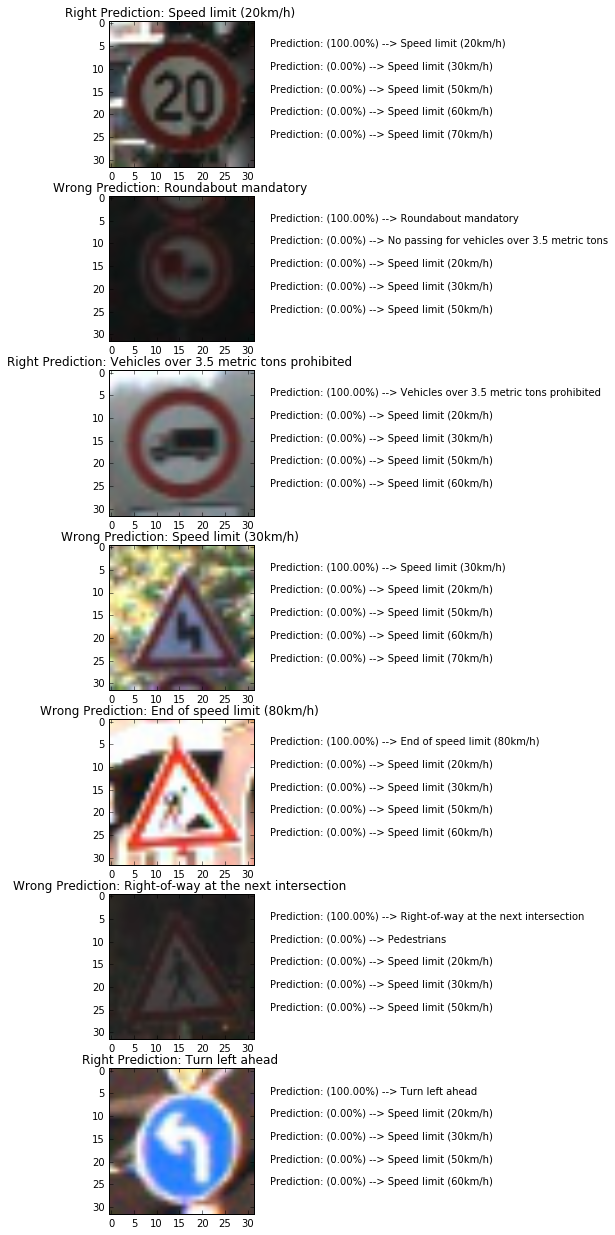

In [61]:
tsc.__init__(norm=True,epochs=200, rate=0.0001,learning_curve=True,keep_prob=0.5,save_model=True,test_model=True,new_image=True,batch_size=128)
color =['YUV']
for name in color:
    print('Color Space: {}'.format(name))
    print("preprocessing...")
    tsc.X_train = tsc.preprocess_data(tsc.X_train,name)
    tsc.X_valid = tsc.preprocess_data(tsc.X_valid,name)
    print("preprocessing Completed")
    tsc.X_test = tsc.preprocess_data(tsc.X_test,name)
    tsc.training_pipeline(name)  

The training accuracy is 0.999 and the validation acccuracy is 0.946. The testing accuracy is 0.939 while the web image accuracy is 0.428